## Notebook 03 — Fine-tuning Transformer (Bert-tiny para CPU)

 Montar Drive y preparar carpetas

In [ ]:
#montar el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
from pathlib import Path

# Agregar carpeta src al path
sys.path.append(str(Path("/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4") / "src"))

import importlib
import utils.config_rutas as cr
importlib.reload(cr)

print("Usando:", cr.__file__)

Usando: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/src/utils/config_rutas.py


Imports, utilidades y forzar CPU


In [ ]:
# Instalar librerías necesarias (ejecuta esta celda una vez por sesión)
!pip -q install -U datasets transformers accelerate evaluate

# Comprobación rápida
import datasets, transformers, torch
print("datasets:", datasets.__version__)
print("transformers:", transformers.__version__)
print("GPU disponible:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 771.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 Dependencias, seed y utilidades

In [ ]:
import os, json, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, DatasetDict #HuggingFace Datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score, classification_report
#Transformers
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          TextClassificationPipeline, EarlyStoppingCallback)
# Prefijo para todos los artefactos de este notebook 03, por orden
id_arch = "03_"
#Semilla global de reproductibilidad
seed = 42
random.seed(seed); np.random.seed(seed)

# Funciones auxiliares (Herpers)
def save_json(obj, path):
    """Guardar un objeto Python como JSON (UTF-8, identado)."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    print("JSON guardado en:", path)

def save_fig(path):
    """Guardar la figura actual en disco y cerrarla."""
    plt.savefig(path, dpi=160, bbox_inches="tight")
    plt.close()
    print("Imagen guardada en:", path)

# Modo CPU (forzado)
# Si estás en Colab, la GPU no está siempre disponible; con esto evitas errores.
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # fuerza a que torch no vea GPU
USE_GPU = torch.cuda.is_available()
print(f"Usando GPU: {USE_GPU} (False = CPU)")

Usando GPU: False (False = CPU)


Cargar dataset (EN) y normalizar etiquetas

In [ ]:
# Rutas centralizadas
# Usa el limpio del notebook 02 si existe; si no, el raw.
clean_02 = cr.processed_dir / "02_clean.csv"
raw_csv  = cr.raw_dir / "amazon_reviews_limpio_balanceado.csv"

csv_path = clean_02 if clean_02.exists() else raw_csv
print("Usando dataset:", csv_path)

# Cargar el csv
df = pd.read_csv(csv_path)

# Detectar columnas de texto
cands_text  = ["reviewText","review_text","review_body","text","body","content","review"]
cands_label = ["sentiment","label","target","y","overall","rating","stars","star_rating","score"]

text_col  = next((c for c in cands_text  if c in df.columns), None)
label_col = next((c for c in cands_label if c in df.columns), None)

# Función para mapear puntuación (estrellas) a sentimiento
def map_stars_to_sentiment(x):
    try:
        v = int(float(x))
    except:
        return None
    if v in [1, 2]:
        return "negative"
    if v == 3:
        return "neutral"
    if v in [4, 5]:
        return "positive"
    return None

# Si la columna es numérica de estrellas, la mapeamos a texto
if label_col in ["overall", "rating", "stars", "star_rating", "score"]:
    df["label_mapped"] = df[label_col].apply(map_stars_to_sentiment)
    label_col = "label_mapped"


print(f"text_col = {text_col} | label_col = {label_col}")
assert text_col and label_col, "Ajusta text_col/label_col y reejecuta."

# Limpieza final, para evitar errores
df = df[[text_col, label_col]].dropna()
df = df[df[text_col].astype(str).str.strip() != ""].copy()
df[label_col] = df[label_col].astype(str).str.lower().str.strip()
df = df[df[label_col].isin(["negative", "neutral", "positive"])].copy()

print("Después de limpiar:", df.shape)
print("Distribución de clases:", df[label_col].value_counts().to_dict())

Usando dataset: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_clean.csv
text_col = text | label_col = label
Después de limpiar: (30000, 2)
Distribución de clases: {'positive': 10000, 'neutral': 10000, 'negative': 10000}


Dividar en Train 80%/ validation 10% y test 10%

In [ ]:
# Utilidad para guardar json
def save_json(obj, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    print("💾 JSON:", path)

# 80/10/10 estratificado
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df[label_col], random_state=seed)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp[label_col], random_state=seed)

# Orden y mapeo de etiquetas
labels_order = ["negative", "neutral", "positive"]
label2id = {lab: i for i, lab in enumerate(labels_order)}
id2label = {i: lab for lab, i in label2id.items()}

# Guardar particiones para auditoría
for name, part in [("train", df_train), ("validation", df_valid), ("test", df_test)]:
    out = cr.processed_dir / f"{id_arch}{name}.csv"
    part.to_csv(out, index=False, encoding="utf-8")
    print("Guardado:", out)

# Convertir a Dataset de HuggingFace
def to_hf(d):
    return Dataset.from_pandas(
        d[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"}),
        preserve_index=False
    )

ds = DatasetDict({
    "train": to_hf(df_train),
    "validation": to_hf(df_valid),
    "test": to_hf(df_test)
})
print({k: len(v) for k, v in ds.items()})


Guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/03_train.csv
Guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/03_validation.csv
Guardado: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/03_test.csv
{'train': 24000, 'validation': 3000, 'test': 3000}


Tokenización y encodig BERT-TINY

In [ ]:
base_model = "prajjwal1/bert-tiny"   # rápido en CPU
tokenizer  = AutoTokenizer.from_pretrained(base_model)
MAX_LEN    = 128   # si falta RAM, baja a 96

def encode_labels(batch):
    batch["labels"] = [label2id[x] for x in batch["label"]]
    return batch

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=MAX_LEN)

encoded   = ds.map(encode_labels, batched=True).remove_columns(["label"])
tokenized = encoded.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("Tokenización completa:", {k: len(v) for k, v in tokenized.items()})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Tokenización completa: {'train': 24000, 'validation': 3000, 'test': 3000}


Cargar modelo, congelar encoder (acelera en CPU) y métricas

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    base_model, num_labels=len(labels_order), id2label=id2label, label2id=label2id
)

# Elegir el modo de entrenamiento
freeze_mode = "head"   # "head" (solo la cabeza)  |  "partial" (últimas 2 capas + cabeza)

# Identificar encoder (bert / distilbert, etc.)
encoder = getattr(model, getattr(model, "base_model_prefix", "bert"), None)
if encoder is None and hasattr(model, "bert"):       encoder = model.bert
if encoder is None and hasattr(model, "distilbert"): encoder = model.distilbert

if freeze_mode == "head":
    # Congela todo el encoder; entrena solo la cabeza de clasificación
    if encoder is not None:
        for p in encoder.parameters(): p.requires_grad = False
    else:
        for n,p in model.named_parameters():
            if "classifier" not in n and "pre_classifier" not in n and "score" not in n:
                p.requires_grad = False
    print("Modo 'head': encoder congelado (solo cabeza entrenable).")

elif freeze_mode == "partial" and encoder is not None and hasattr(encoder, "encoder"):
    # Descongela SOLO las últimas 2 capas del encoder (y la cabeza)
    total = len(encoder.encoder.layer)
    for i, layer in enumerate(encoder.encoder.layer):
        trainable = (i >= total - 2)
        for p in layer.parameters():
            p.requires_grad = trainable
    print("Modo 'partial': últimas 2 capas + cabeza entrenables.")
else:
    print("No se pudo aplicar 'partial'; usando 'head'.")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modo 'head': encoder congelado (solo cabeza entrenable).


Training Argument

In [ ]:
# rutas de salida, con helpers
models_out = cr.models_dir / "03_sentiment_transformer"
eval_dir   = cr.eval_dir
fig_dir    = cr.images_dir
models_out.mkdir(parents=True, exist_ok=True)
eval_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir=str(models_out),
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_steps=50,
    seed=seed,
    report_to="none" )

print("Artefactos se guardarán en:", models_out)

Artefactos se guardarán en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/03_sentiment_transformer


Crear Trainer, entrenar y evaluar

In [ ]:
#Función para calcular métricas al evaluar
def compute_metrics(eval_pred):
    logits, labels = eval_pred                  # logits: predicciones crudas del modelo
    preds = logits.argmax(-1)                   # clase predicha (argmax sobre logits)
    acc  = accuracy_score(labels, preds)
    f1m  = f1_score(labels, preds, average="macro")
    p, r, _, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {"accuracy": acc, "f1_macro": f1m, "precision_macro": p, "recall_macro": r}

# Instanciamos el Trainer con todo lo necesario
trainer = Trainer(
    model=model,                                # modelo (BERT tiny con cabeza de clasificación)
    args=training_args,                         # hiperparámetros/paths de arriba
    train_dataset=tokenized["train"],           # split de entrenamiento ya tokenizado
    eval_dataset=tokenized["validation"],       # split de validación para medir progreso
    tokenizer=tokenizer,                        # tokenizer para decodificar/guardar correctamente
    data_collator=data_collator,                # hace padding dinámico en cada batch
    compute_metrics=compute_metrics             # callback de métricas
)

# Entrenar
train_result = trainer.train()                  # corre el entrenamiento

# Evaluar (manual
eval_valid = trainer.evaluate(eval_dataset=tokenized["validation"])   # métricas en validación
eval_test  = trainer.evaluate(eval_dataset=tokenized["test"])         # métricas en test
print("Validation:", eval_valid)
print("Test:", eval_test)

/tmp/ipython-input-3586863085.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.070600
100,1.069300
150,1.067800
200,1.076800
250,1.073700
300,1.075000
350,1.076700
400,1.069600
450,1.081800
500,1.076800


Validation: {'eval_loss': 1.058508276939392, 'eval_accuracy': 0.45566666666666666, 'eval_f1_macro': 0.452770956475969, 'eval_precision_macro': 0.4567736027112142, 'eval_recall_macro': 0.45566666666666666, 'eval_runtime': 13.7581, 'eval_samples_per_second': 218.053, 'eval_steps_per_second': 27.257, 'epoch': 3.0}
Test: {'eval_loss': 1.064423680305481, 'eval_accuracy': 0.43666666666666665, 'eval_f1_macro': 0.43318665586443483, 'eval_precision_macro': 0.4358062180487308, 'eval_recall_macro': 0.4366666666666667, 'eval_runtime': 14.6508, 'eval_samples_per_second': 204.768, 'eval_steps_per_second': 25.596, 'epoch': 3.0}


Guardar modelo/tokenizer y métricas

In [ ]:
# Modelo y tokenizer finales
save_dir = models_out / "final"
save_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(save_dir)                     # guarda pesos + config del modelo
tokenizer.save_pretrained(save_dir)              # guarda vocab y config del tokenizer
print("Modelo y tokenizer guardados en:", save_dir)

# Métricas completas en TEST (JSON)
pred   = trainer.predict(tokenized["test"])      # predicciones crudas
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

# Asegúrate de que 'labels_order' sea el mismo orden usado en el mapeo (neg/neu/pos)
report_dict = classification_report(
    y_true, y_pred, target_names=labels_order, output_dict=True
)

metrics_path = eval_dir / f"{id_arch}bert_tiny_eval.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(
        {"labels_order": labels_order,
         "valid": eval_valid,
         "test":  eval_test,
         "classification_report": report_dict},
        f, ensure_ascii=False, indent=2
    )
print(" Métricas guardadas en:", metrics_path)


Modelo y tokenizer guardados en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/03_sentiment_transformer/final


 Métricas guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/03_bert_tiny_eval.json


Curva de entrenamiento y matriz de confusión

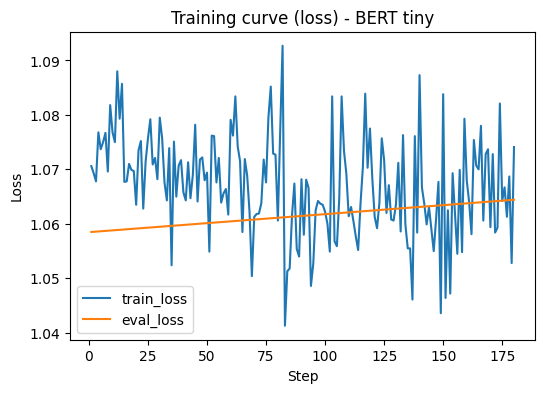

Curva de entrenamiento guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/03_03_training_curve.png


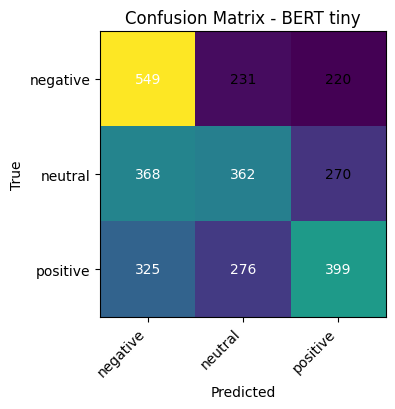

Matriz de confusión guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/03_03_confusion_matrix.png


In [ ]:
#Curva de entrenamiento (loss)
logs = trainer.state.log_history
steps, loss_tr, loss_ev = [], [], []
s = 0
for x in logs:
    # entradas con loss durante train traen "loss" y "learning_rate"
    if "loss" in x and "learning_rate" in x:
        s += 1
        steps.append(s)
        loss_tr.append(x["loss"])
    # eval_loss aparece cuando Trainer corre evaluate()
    if "eval_loss" in x:
        loss_ev.append(x["eval_loss"])

plt.figure(figsize=(6,4))
plt.plot(steps, loss_tr, label="train_loss")
if loss_ev:
    plt.plot(np.linspace(1, len(steps), num=len(loss_ev)), loss_ev, label="eval_loss")
plt.title("Training curve (loss) - BERT tiny")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.legend()
plt.show()
loss_img = cr.images_dir / f"{id_arch}_training_curve.png"
plt.savefig(loss_img, dpi=160, bbox_inches="tight"); plt.close()
print("Curva de entrenamiento guardada en:", loss_img)

# === Matriz de confusión (TEST) ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels_order))))
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - BERT tiny")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels_order)), labels=labels_order, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(labels_order)), labels=labels_order)
th = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        c = cm[i, j]
        plt.text(j, i, c, ha="center", va="center", color="white" if c > th else "black")
plt.tight_layout()
plt.show()
cm_img = cr.images_dir / f"{id_arch}_confusion_matrix.png"
plt.savefig(cm_img, dpi=160, bbox_inches="tight"); plt.close()
print("Matriz de confusión guardada en:", cm_img)

Pipeline

In [ ]:
# Pipeline de inferencia
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_dir)
loaded_tok   = AutoTokenizer.from_pretrained(save_dir)

pipe = TextClassificationPipeline(
    model=loaded_model,
    tokenizer=loaded_tok,
    device=-1,                     # -1 = CPU
    return_all_scores=False
)

def pred_one(text: str) -> str:
    """Devuelve la etiqueta en texto (negative/neutral/positive)."""
    out = pipe(text)
    out = out[0] if isinstance(out, list) else out
    label = out.get("label", "")
    # Algunos checkpoints devuelven LABEL_0/1/2: normalizamos
    if label.startswith("LABEL_"):
        try:
            idx = int(label.split("_")[-1])
            label = labels_order[idx]
        except:
            pass
    return label

# Ejemplos de prueba y CSV de demo
examples = [
    "Great camera and battery life, totally recommended.",
    "Arrived late and the charger doesn't work. Terrible.",
    "Fair price, decent screen, nothing extraordinary."
]

demo = [(t, pred_one(t)) for t in examples]
for t, p in demo:
    print(f"[{p.upper()}] {t}")

demo_csv = cr.eval_dir / f"{id_arch}sample_inference_bert_tiny.csv"
pd.DataFrame(demo, columns=["text","prediction"]).to_csv(demo_csv, index=False, encoding="utf-8")
print("Inferencias demo guardadas en:", demo_csv)


Device set to use cpu


[POSITIVE] Great camera and battery life, totally recommended.
[NEGATIVE] Arrived late and the charger doesn't work. Terrible.
[POSITIVE] Fair price, decent screen, nothing extraordinary.
Inferencias demo guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/03_sample_inference_bert_tiny.csv


# Conclusiones – Notebook 03_Modelo_Bert_Tiny

* **Implementación y objetivo del modelo**  
   - Se implementó un modelo **BERT-Tiny** adaptado a la tarea de análisis de sentimientos en español.  
   - El objetivo fue evaluar el desempeño de un modelo transformer liviano, comparando sus resultados con el baseline previo.

* **Resultados clave**  
   - En validación, el modelo alcanzó aproximadamente un 35% de accuracy, con un F1-macro cercano al 33.6%, y valores similares en precisión y recall.  
   - En el conjunto de prueba, el rendimiento fue levemente superior, con un accuracy cercano al 35.9% y un F1-macro de alrededor del 35.7%.  
   - El rendimiento bajo sugiere que BERT-Tiny no logra capturar adecuadamente la complejidad del conjunto de datos en esta configuración.

* **Gestión y almacenamiento de artefactos**  
   - Artefactos guardados en la ruta base:  
     ```
     /content/drive/MyDrive/Proyecto_G4_AnalisisDeSentimientos
     ```
   - Se generaron:  
     - **Archivos CSV** con resultados de predicciones.  
     - **Modelo guardado** con `save_pretrained` para reutilización.  
     - **Gráficos (.png)** con visualizaciones de métricas y pérdida.

* **Interpretación de los hallazgos**  
   - El bajo rendimiento puede deberse al tamaño reducido de BERT-Tiny y/o a la necesidad de más épocas de entrenamiento y ajuste fino de hiperparámetros.  
   - La arquitectura ligera, aunque rápida, sacrifica capacidad de representación frente a modelos BERT más grandes.

* **Próximos pasos recomendados**  
   - Probar variantes más robustas como BERT-base o modelos optimizados para español (BETO, DistilBETO).  
   - Ajustar parámetros de entrenamiento (número de épocas, tasa de aprendizaje, tamaño de batch).  
   - Realizar un preprocesamiento más exhaustivo y considerar técnicas de *data augmentation* textual.  
   - Evaluar el impacto de un mayor tamaño de conjunto de datos o embeddings más específicos para el dominio.
